In [1]:
import torch
import torchvision
import os
from pathlib import Path
try :
    import torchinfo
except:
    !pip install torchinfo

from torchinfo import summary
import glob

In [2]:
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 30.25 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
weights=torchvision.models.EfficientNet_V2_M_Weights.DEFAULT
effnet_v2_m_transformer=torchvision.models.EfficientNet_V2_M_Weights.IMAGENET1K_V1.transforms
effnet_v2_m=torchvision.models.efficientnet_v2_m(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:02<00:00, 103MB/s]


In [5]:
data_dir=Path('/data')
train_dir=torchvision.datasets.Food101(root=data_dir,split='train',transform=effnet_v2_m_transformer,download=True)
test_dir=torchvision.datasets.Food101(root=data_dir,split='test',transform=effnet_v2_m_transformer,download=True)

100%|██████████| 4996278331/4996278331 [02:55<00:00, 28501981.37it/s]


Extracting /data/food-101.tar.gz to /data


In [6]:
summary(model=effnet_v2_m,
        input_size=(32, 3, 480, 480), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 480, 480]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 480, 480]    [32, 1280, 15, 15]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 480, 480]    [32, 24, 240, 240]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 480, 480]    [32, 24, 240, 240]   648                  True
│    │    └─BatchNorm2d (1)                                  [32, 24, 240, 240]   [32, 24, 240, 240]   48                   True
│    │    └─SiLU (2)                                         [32, 24, 240, 240]   [32, 24, 240, 240]   --                   --
│    └─Sequential (1)                                        [32, 24, 240, 240]   [32, 24, 240

In [42]:
weights=torchvision.models.ResNet50_Weights.DEFAULT
#Resnet50_transformer=weights.transforms
resnet_50=torchvision.models.resnet50(weights=weights).to(device)

In [43]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    torchvision.transforms.Resize(256,interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    torchvision.transforms.CenterCrop(size=224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

])
food101_test_transforms=torchvision.transforms.Compose([
    #torchvision.transforms.TrivialAugmentWide(),
    torchvision.transforms.Resize(256,interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    torchvision.transforms.CenterCrop(size=224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

])

In [30]:
from PIL import Image
x=Image.open("/content/data/food-101/images/apple_pie/1005649.jpg")

In [41]:
food101_train_transforms(x)

tensor([[[ 0.1254,  0.1083,  0.0741,  ..., -0.3883, -0.0287,  0.3309],
         [ 0.4851,  0.5364,  0.4337,  ..., -0.2856, -0.2513, -0.0287],
         [ 0.6049,  0.5364,  0.2967,  ...,  0.3481, -0.0801, -0.3369],
         ...,
         [-0.2171,  0.2967,  0.2796,  ..., -1.1760, -1.2103, -1.0733],
         [ 0.0912,  0.3823,  0.1254,  ..., -0.7137, -0.9705, -1.0219],
         [ 0.1768,  0.3994,  0.2282,  ..., -0.3027, -0.7479, -1.0562]],

        [[ 0.2577,  0.2402,  0.2052,  ..., -0.3725, -0.0049,  0.3803],
         [ 0.6254,  0.6779,  0.5728,  ..., -0.2675, -0.2325,  0.0126],
         [ 0.7479,  0.6779,  0.4328,  ...,  0.3803, -0.0574, -0.2850],
         ...,
         [-0.0399,  0.4853,  0.4678,  ..., -1.1253, -1.1779, -1.0728],
         [ 0.2402,  0.5553,  0.2752,  ..., -0.6352, -0.9153, -1.0203],
         [ 0.3277,  0.5553,  0.3803,  ..., -0.1975, -0.6877, -1.0378]],

        [[ 0.4265,  0.4091,  0.3742,  ..., -0.2184,  0.1476,  0.5136],
         [ 0.7925,  0.8448,  0.7402,  ..., -0

In [45]:
resnet_50.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [46]:
for param in resnet_50.parameters():
    param.requires_grad=False

In [47]:
resnet_50.fc=torch.nn.Linear(in_features=2048,out_features=101)

In [48]:
summary(model=resnet_50,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 101]            --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [49]:
data_dir=Path('data')
train_dir=torchvision.datasets.Food101(root=data_dir,split='train',transform=food101_train_transforms,download=True)
test_dir=torchvision.datasets.Food101(root=data_dir,split='test',transform=food101_test_transforms,download=True)

In [50]:
class_names=train_dir.classes
len(class_names)

101

In [51]:
paths=list(glob.glob("/content/data/food-101/images/apple_pie/*.jpg"))
len(paths)

1000

In [52]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [53]:
train_data_half,_=split_dataset(dataset=train_dir,split_size=0.4)
test_data_half,_=split_dataset(dataset=test_dir,split_size=0.4)


[INFO] Splitting dataset of length 75750 into splits of size: 30300 (40%), 45450 (60%)
[INFO] Splitting dataset of length 25250 into splits of size: 10100 (40%), 15150 (60%)


In [54]:
train_dataloader=torch.utils.data.DataLoader(dataset=train_data_half,batch_size=32,shuffle=True,)
test_dataloader=torch.utils.data.DataLoader(dataset=test_data_half,batch_size=32,shuffle=False)

In [56]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=resnet_50.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
torch.manual_seed(42)
torch.cuda.manual_seed(42)
resnet50_results = engine.train(model=resnet_50,
                                        train_dataloader=train_dataloader,
                                        test_dataloader=test_dataloader,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=10,
                                        device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.2255 | train_acc: 0.3730 | test_loss: 2.4349 | test_acc: 0.5627
Epoch: 2 | train_loss: 2.4947 | train_acc: 0.5402 | test_loss: 2.2084 | test_acc: 0.6126
Epoch: 3 | train_loss: 2.2859 | train_acc: 0.5962 | test_loss: 2.1308 | test_acc: 0.6276
Epoch: 4 | train_loss: 2.1620 | train_acc: 0.6300 | test_loss: 2.0894 | test_acc: 0.6385
Epoch: 5 | train_loss: 2.0838 | train_acc: 0.6519 | test_loss: 2.0781 | test_acc: 0.6426
Epoch: 6 | train_loss: 2.0234 | train_acc: 0.6682 | test_loss: 2.0626 | test_acc: 0.6459
Epoch: 7 | train_loss: 1.9736 | train_acc: 0.6826 | test_loss: 2.0555 | test_acc: 0.6467
Epoch: 8 | train_loss: 1.9345 | train_acc: 0.6974 | test_loss: 2.0773 | test_acc: 0.6430
Epoch: 9 | train_loss: 1.9083 | train_acc: 0.7038 | test_loss: 2.0552 | test_acc: 0.6483
Epoch: 10 | train_loss: 1.8769 | train_acc: 0.7157 | test_loss: 2.0585 | test_acc: 0.6494


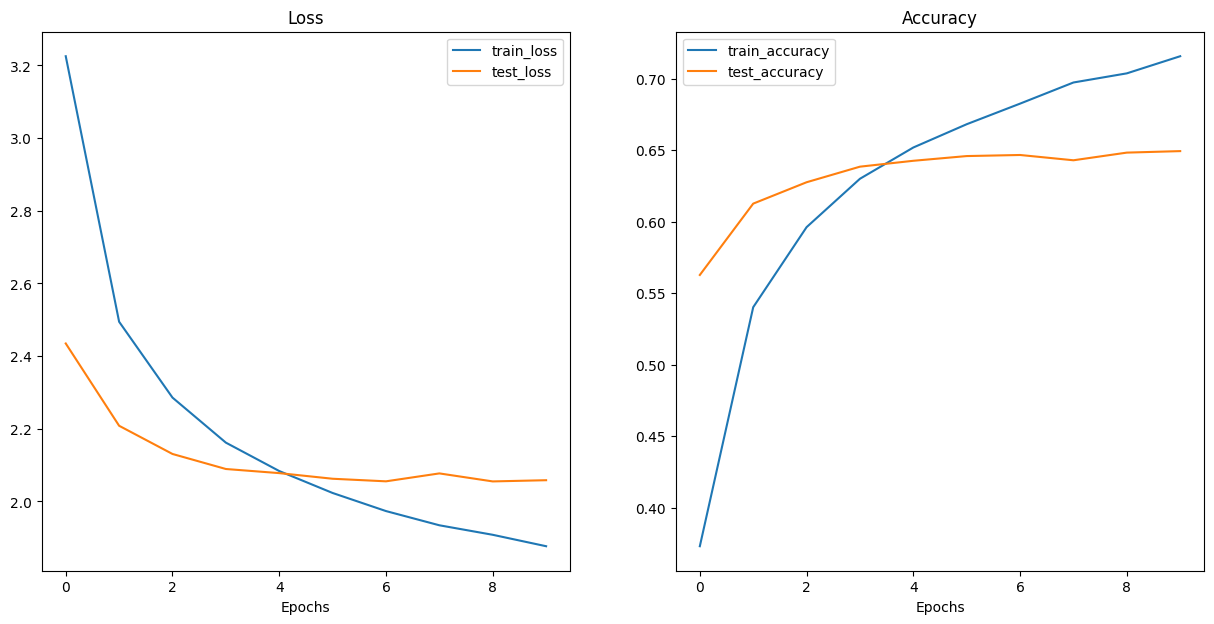

In [59]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(resnet50_results)

In [60]:
save_model_path=Path("models")
save_model_path.mkdir(parents=True,exist_ok=True)

In [63]:
from going_modular.going_modular import utils

# Create a model path
resnet_50_model_path = "pretrained_resnet50_feature_extractor_food101_40_percent.pth"

# Save FoodVision Big model
utils.save_model(model=resnet_50,
                 target_dir="models",
                 model_name=resnet_50_model_path)

[INFO] Saving model to: models/pretrained_resnet50_feature_extractor_food101_40_percent.pth
